same example as dogs v/s cats but now implementing data augmentation

In [1]:
import os
import pickle 

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from io import BytesIO

from ipywidgets import widgets 

2025-07-21 19:37:08.782111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753106828.794720   24830 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753106828.799055   24830 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753106828.809557   24830 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753106828.809573   24830 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753106828.809575   24830 computation_placer.cc:177] computation placer alr

In [2]:
TRAIN_DIR = 'train'
VAL_DIR   = 'test'

train_dogs_dir   = os.path.join(TRAIN_DIR, 'dogs')
train_cats_dir   = os.path.join(TRAIN_DIR, 'cats')
validate_dogs_dir = os.path.join(VAL_DIR, 'dogs')
validate_cats_dir = os.path.join(VAL_DIR, 'cats')

In [3]:
print(f"total training dogs images: {len(os.listdir(train_dogs_dir))}")
print(f"total training cats images: {len(os.listdir(train_cats_dir))}")
print(f"total validation dogs images: {len(os.listdir(validate_dogs_dir))}")
print(f"total validation cats images: {len(os.listdir(validate_cats_dir))}")

total training dogs images: 10000
total training cats images: 10000
total validation dogs images: 2500
total validation cats images: 2500


this method of previewing allows to see different resolutions of each image

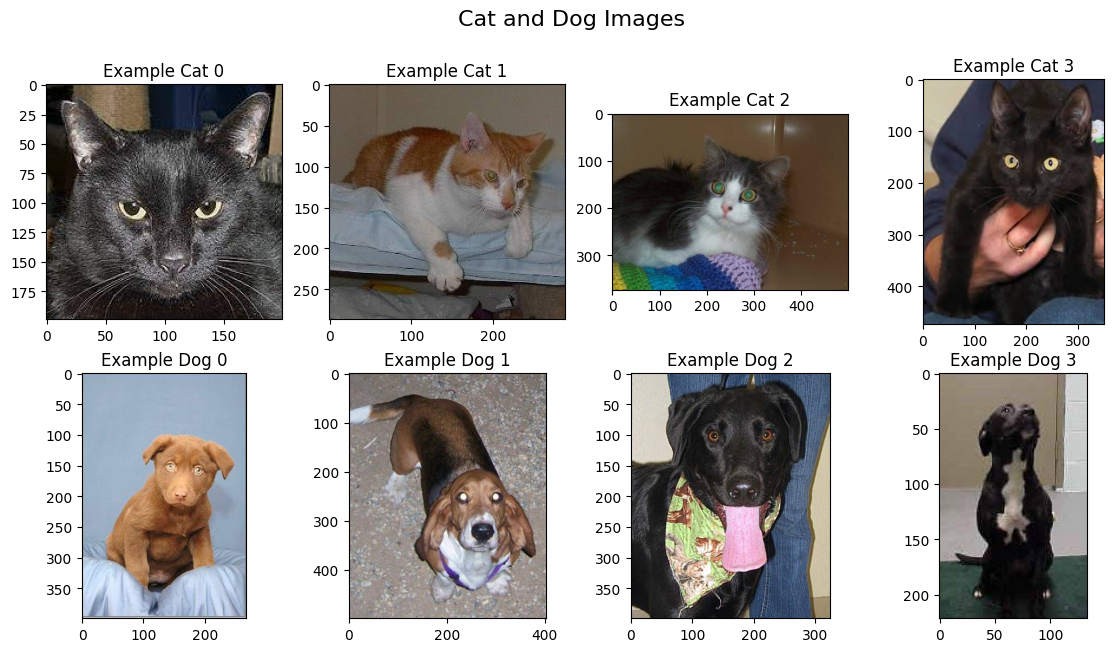

In [4]:
cats_filenames = [os.path.join(train_cats_dir, filename) for filename in os.listdir(train_cats_dir)]
dogs_filenames = [os.path.join(train_dogs_dir, filename) for filename in os.listdir(train_dogs_dir)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Cat and Dog Images', fontsize=16)

for i, cat_image in enumerate(cats_filenames[:4]):
    img = tf.keras.utils.load_img(cat_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Cat {i}')

for i, dog_image in enumerate(dogs_filenames[:4]):
    img = tf.keras.utils.load_img(dog_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dog {i}')

plt.show()

going for a modular approach this time

In [5]:
def create_augmentation_model():
    
    FILL_MODE = 'nearest'
    augmentation_model = tf.keras.Sequential([ 
		tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2,0.2,fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2 , fill_mode=FILL_MODE)
    ]) 
    
    return augmentation_model

In [6]:
def create_model():

    augmentation_layers = create_augmentation_model()

    model = tf.keras.models.Sequential([ 
		tf.keras.Input(shape=(150,150,3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    ]) 
  
    model.compile( 
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy'] 
    ) 
    
    return model

In [7]:
model_summary = create_model()
model_summary.summary()

I0000 00:00:1753106831.396406   24830 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4932 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size = (150,150),
    batch_size = 128,
    label_mode = 'binary',
    seed=42 
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size = (150,150),
    batch_size = 128,
    label_mode = 'binary',
    seed=42
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [9]:
SHUFFLE_BATCH_SIZE = 1000
PREFETCH_BATCH_SIZE = tf.data.AUTOTUNE

final_training_dataset = (train_dataset
                          .cache()
                          .shuffle(SHUFFLE_BATCH_SIZE)
                          .prefetch(PREFETCH_BATCH_SIZE)
                          )

final_validation_dataset = (validation_dataset
                          .cache()
                          .prefetch(PREFETCH_BATCH_SIZE)
                          )

In [10]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('accuracy') >=0.8 and logs.get('val_accuracy') >=0.75:
            self.model.stop_training = True 

actually training the model now

In [11]:
model = create_model()

history = model.fit(
    final_training_dataset,
    epochs = 150 ,
    validation_data = final_validation_dataset,
    callbacks=[EarlyStopping()],
    verbose = 2
)

Epoch 1/150


I0000 00:00:1753106840.391717   24908 cuda_dnn.cc:529] Loaded cuDNN version 91002


157/157 - 22s - 143ms/step - accuracy: 0.5692 - loss: 0.6879 - val_accuracy: 0.6642 - val_loss: 0.6154
Epoch 2/150
157/157 - 12s - 79ms/step - accuracy: 0.6597 - loss: 0.6223 - val_accuracy: 0.6894 - val_loss: 0.5902
Epoch 3/150
157/157 - 12s - 79ms/step - accuracy: 0.6785 - loss: 0.5951 - val_accuracy: 0.7040 - val_loss: 0.5667
Epoch 4/150
157/157 - 13s - 81ms/step - accuracy: 0.6968 - loss: 0.5737 - val_accuracy: 0.7090 - val_loss: 0.5560
Epoch 5/150
157/157 - 13s - 82ms/step - accuracy: 0.7031 - loss: 0.5639 - val_accuracy: 0.7386 - val_loss: 0.5271
Epoch 6/150
157/157 - 12s - 79ms/step - accuracy: 0.7208 - loss: 0.5484 - val_accuracy: 0.7408 - val_loss: 0.5187
Epoch 7/150
157/157 - 13s - 81ms/step - accuracy: 0.7299 - loss: 0.5370 - val_accuracy: 0.7232 - val_loss: 0.5450
Epoch 8/150
157/157 - 13s - 84ms/step - accuracy: 0.7345 - loss: 0.5287 - val_accuracy: 0.7380 - val_loss: 0.5158
Epoch 9/150
157/157 - 13s - 81ms/step - accuracy: 0.7417 - loss: 0.5202 - val_accuracy: 0.7526 - va

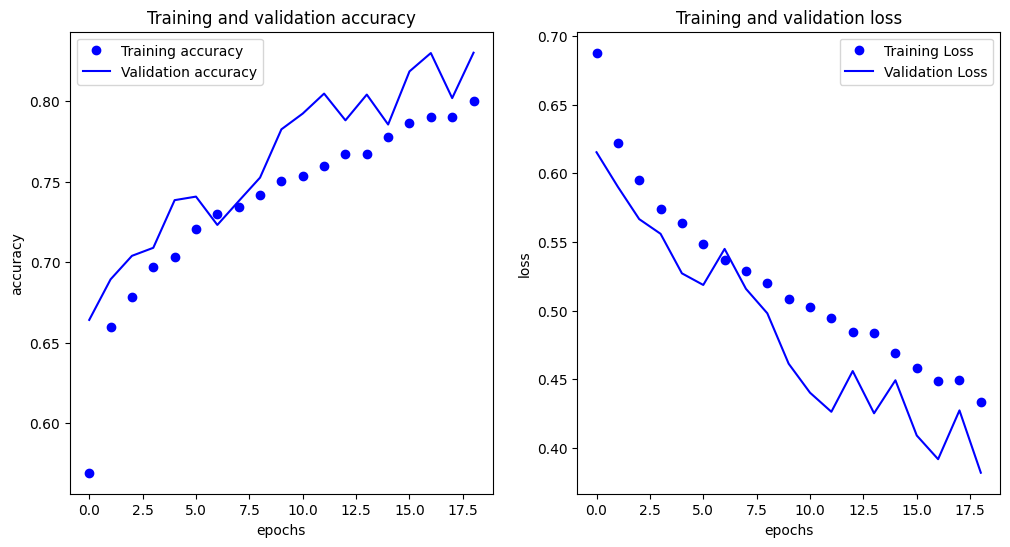

In [12]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

testing time again

In [13]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        print(f"Raw prediction for {filename}: {prediction:.4f}")
        if prediction > 0.5:
            print(filename + " is a dog")
        else:
            print(filename + " is a cat")


def on_upload_change(change):
    
    items = change.new
    for item in items: 
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()